# 03 - Results & Visualization

Visualize and present results from the Random Forest district classifier.

**Goal:** Create publication-quality visualizations and summary statistics.

**Visualizations:**
1. Confusion matrix heatmap
2. Per-district performance metrics
3. Feature importance (embedding dimensions)
4. Sample predictions analysis

## Setup

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

# Add backbone to path
project_root = Path.cwd().parent.parent.parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Current project: {Path.cwd().parent.name}")

Project root: c:\Users\Arnav\Documents\Python Scripts\bird embeddings
Current project: district_prediction


## 1. Load Data and Model

In [2]:
# Load processed data
data_path = Path('../data/processed/embeddings_with_districts.npz')
data = np.load(data_path, allow_pickle=True)

X = data['embeddings']
y = data['districts']

print(f'✓ Loaded data')
print(f'  Samples: {len(X):,}')
print(f'  Features: {X.shape[1]}')
print(f'  Districts: {len(np.unique(y))}')

✓ Loaded data
  Samples: 64,884
  Features: 16
  Districts: 14


In [3]:
# Load trained model
model_path = Path('../models/district_classifier.pkl')
clf = joblib.load(model_path)

print(f'✓ Loaded Random Forest model')
print(f'  Trees: {clf.n_estimators}')
print(f'  Max depth: {clf.max_depth}')

✓ Loaded Random Forest model
  Trees: 200
  Max depth: 20


In [4]:
# Recreate train/test split (same random_state as analysis)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Get predictions
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

train_acc = (y_train_pred == y_train).mean()
test_acc = (y_pred == y_test).mean()

print(f'\nModel Performance:')
print(f'  Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)')
print(f'  Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)')

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s



Model Performance:
  Train Accuracy: 0.9242 (92.42%)
  Test Accuracy:  0.6745 (67.45%)


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.4s finished


## 2. Confusion Matrix

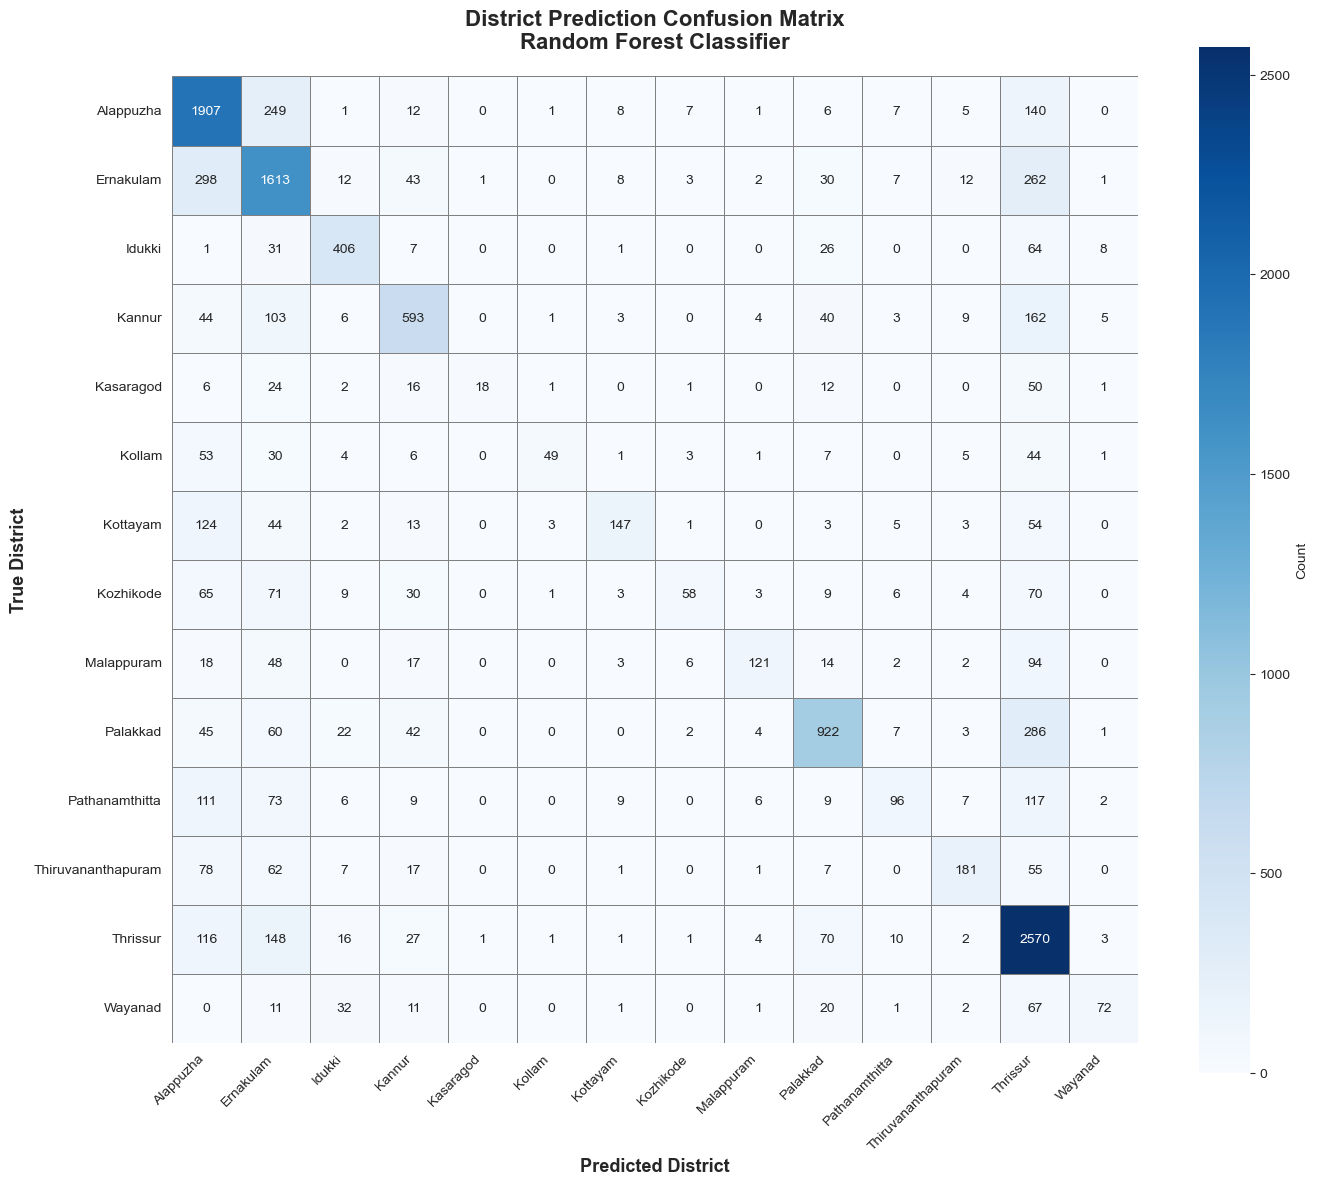

✓ Saved confusion matrix to: ..\results\figures\confusion_matrix.png


In [5]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
districts = clf.classes_

# Create heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=districts,
    yticklabels=districts,
    cbar_kws={'label': 'Count'},
    square=True,
    linewidths=0.5,
    linecolor='gray'
)

plt.title('District Prediction Confusion Matrix\nRandom Forest Classifier', 
          fontsize=16, pad=20, fontweight='bold')
plt.ylabel('True District', fontsize=13, fontweight='bold')
plt.xlabel('Predicted District', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save figure
fig_path = Path('../results/figures')
fig_path.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'✓ Saved confusion matrix to: {fig_path / "confusion_matrix.png"}')

## 3. Per-District Performance

In [6]:
# Get classification report
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Create dataframe
metrics_df = pd.DataFrame({
    'District': districts,
    'Precision': [report_dict[d]['precision'] for d in districts],
    'Recall': [report_dict[d]['recall'] for d in districts],
    'F1-Score': [report_dict[d]['f1-score'] for d in districts],
    'Support': [report_dict[d]['support'] for d in districts]
}).sort_values('F1-Score', ascending=False).reset_index(drop=True)

print('\nPer-District Metrics (sorted by F1-Score):')
print('='*70)
print(metrics_df.to_string(index=False))
print('='*70)


Per-District Metrics (sorted by F1-Score):
          District  Precision   Recall  F1-Score  Support
            Idukki   0.773333 0.746324  0.759588    544.0
          Thrissur   0.636927 0.865320  0.733762   2970.0
         Alappuzha   0.665387 0.813567  0.732054   2344.0
          Palakkad   0.784681 0.661406  0.717789   1394.0
         Ernakulam   0.628360 0.703752  0.663923   2292.0
            Kannur   0.703440 0.609455  0.653084    973.0
Thiruvananthapuram   0.770213 0.442543  0.562112    409.0
        Malappuram   0.817568 0.372308  0.511628    325.0
          Kottayam   0.790323 0.368421  0.502564    399.0
           Wayanad   0.765957 0.330275  0.461538    218.0
            Kollam   0.859649 0.240196  0.375479    204.0
    Pathanamthitta   0.666667 0.215730  0.325976    445.0
         Kozhikode   0.707317 0.176292  0.282238    329.0
         Kasaragod   0.900000 0.137405  0.238411    131.0


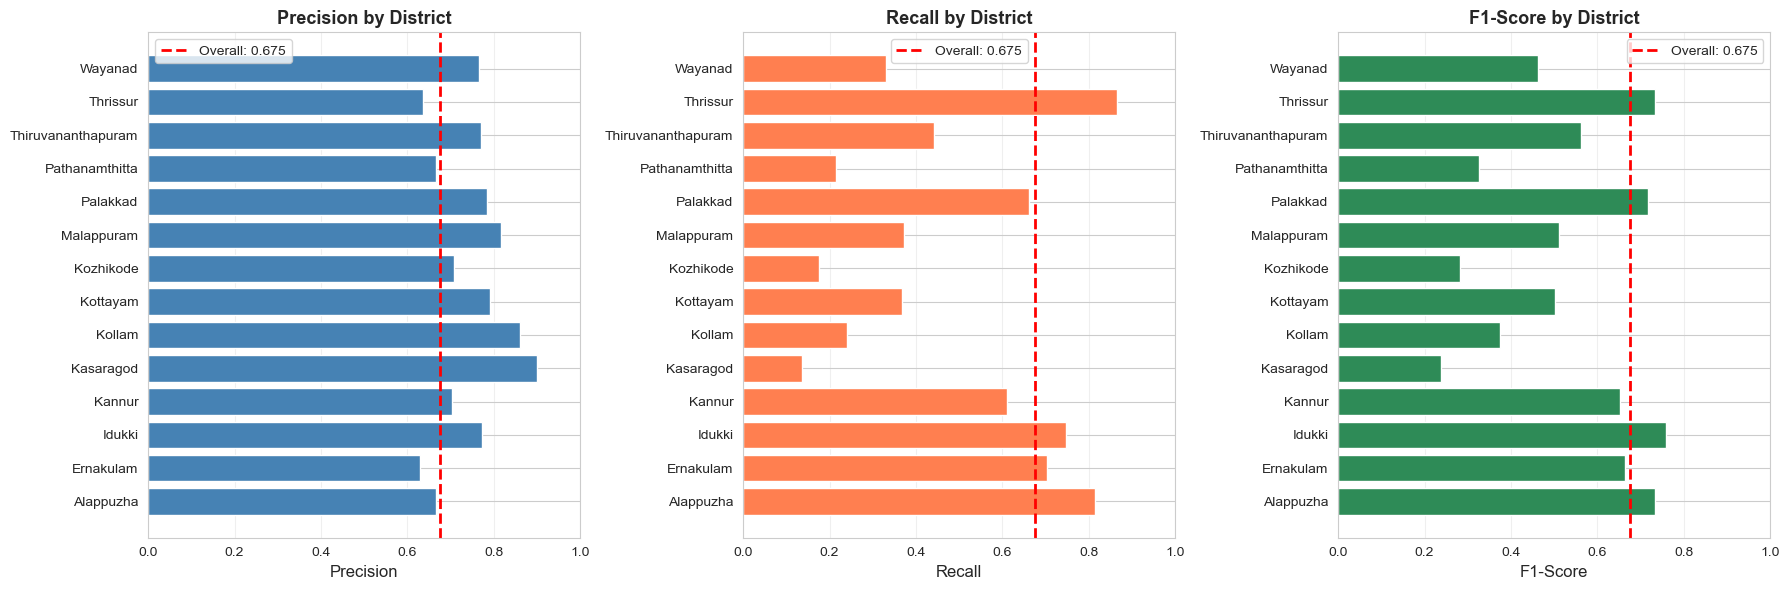

✓ Saved per-district metrics to: ..\results\figures\per_district_metrics.png


In [7]:
# Plot per-district metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Sort by district name for consistent plotting
plot_df = metrics_df.sort_values('District')

# Precision
axes[0].barh(plot_df['District'], plot_df['Precision'], color='steelblue')
axes[0].set_xlabel('Precision', fontsize=12)
axes[0].set_title('Precision by District', fontsize=13, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].axvline(x=test_acc, color='red', linestyle='--', linewidth=2, label=f'Overall: {test_acc:.3f}')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Recall
axes[1].barh(plot_df['District'], plot_df['Recall'], color='coral')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_title('Recall by District', fontsize=13, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].axvline(x=test_acc, color='red', linestyle='--', linewidth=2, label=f'Overall: {test_acc:.3f}')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

# F1-Score
axes[2].barh(plot_df['District'], plot_df['F1-Score'], color='seagreen')
axes[2].set_xlabel('F1-Score', fontsize=12)
axes[2].set_title('F1-Score by District', fontsize=13, fontweight='bold')
axes[2].set_xlim(0, 1)
axes[2].axvline(x=test_acc, color='red', linestyle='--', linewidth=2, label=f'Overall: {test_acc:.3f}')
axes[2].legend()
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(fig_path / 'per_district_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'✓ Saved per-district metrics to: {fig_path / "per_district_metrics.png"}')

## 4. Feature Importance (Embedding Dimensions)

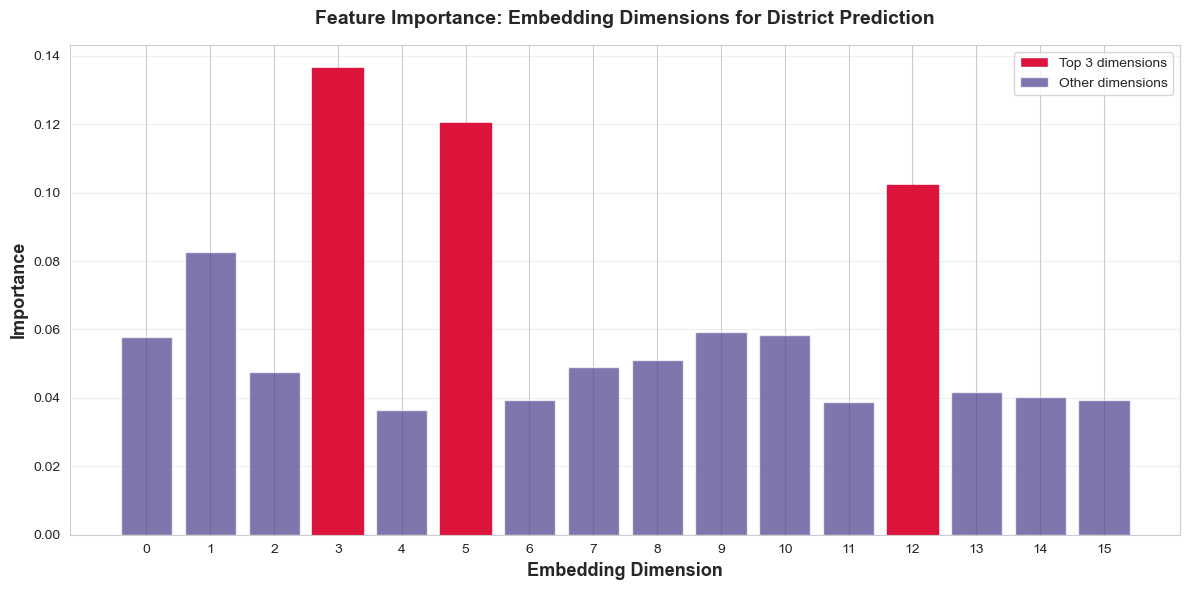

✓ Saved feature importance to: ..\results\figures\feature_importance.png

Top 5 Most Important Embedding Dimensions:
  1. Dimension 3: 0.1364
  2. Dimension 5: 0.1204
  3. Dimension 12: 0.1022
  4. Dimension 1: 0.0827
  5. Dimension 9: 0.0591


In [8]:
# Get feature importances
importances = clf.feature_importances_

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(importances)), importances, color='darkslateblue', alpha=0.7)

# Highlight top 3 most important dimensions
top_dims = np.argsort(importances)[::-1][:3]
for dim in top_dims:
    bars[dim].set_color('crimson')
    bars[dim].set_alpha(1.0)

plt.xlabel('Embedding Dimension', fontsize=13, fontweight='bold')
plt.ylabel('Importance', fontsize=13, fontweight='bold')
plt.title('Feature Importance: Embedding Dimensions for District Prediction', 
          fontsize=14, fontweight='bold', pad=15)
plt.xticks(range(len(importances)))
plt.grid(axis='y', alpha=0.3)

# Add legend for top dimensions
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='crimson', label='Top 3 dimensions'),
    Patch(facecolor='darkslateblue', alpha=0.7, label='Other dimensions')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig(fig_path / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'✓ Saved feature importance to: {fig_path / "feature_importance.png"}')
print(f'\nTop 5 Most Important Embedding Dimensions:')
top_5_dims = np.argsort(importances)[::-1][:5]
for i, dim in enumerate(top_5_dims, 1):
    print(f'  {i}. Dimension {dim}: {importances[dim]:.4f}')

## 5. Prediction Analysis

In [9]:
# Analyze prediction errors
errors_mask = y_test != y_pred
n_errors = errors_mask.sum()
n_correct = (~errors_mask).sum()

print(f'Prediction Summary:')
print(f'  Correct: {n_correct:,} ({n_correct/len(y_test)*100:.2f}%)')
print(f'  Incorrect: {n_errors:,} ({n_errors/len(y_test)*100:.2f}%)')

# Most common misclassifications
if n_errors > 0:
    error_pairs = list(zip(y_test[errors_mask], y_pred[errors_mask]))
    from collections import Counter
    common_errors = Counter(error_pairs).most_common(10)
    
    print(f'\nTop 10 Most Common Misclassifications:')
    print('='*70)
    for (true, pred), count in common_errors:
        print(f'  {true:20s} → {pred:20s}: {count:3d} times')
    print('='*70)

Prediction Summary:
  Correct: 8,753 (67.45%)
  Incorrect: 4,224 (32.55%)

Top 10 Most Common Misclassifications:
  Ernakulam            → Alappuzha           : 298 times
  Palakkad             → Thrissur            : 286 times
  Ernakulam            → Thrissur            : 262 times
  Alappuzha            → Ernakulam           : 249 times
  Kannur               → Thrissur            : 162 times
  Thrissur             → Ernakulam           : 148 times
  Alappuzha            → Thrissur            : 140 times
  Kottayam             → Alappuzha           : 124 times
  Pathanamthitta       → Thrissur            : 117 times
  Thrissur             → Alappuzha           : 116 times


In [10]:
# Sample predictions table
n_samples = 30
sample_df = pd.DataFrame({
    'True District': y_test[:n_samples],
    'Predicted District': y_pred[:n_samples],
    'Correct': y_test[:n_samples] == y_pred[:n_samples]
})

# Add emoji for visual clarity
sample_df['Status'] = sample_df['Correct'].apply(lambda x: '✓' if x else '✗')

print(f'\nSample Predictions (first {n_samples}):')
print('='*70)
print(sample_df[['Status', 'True District', 'Predicted District']].to_string(index=False))
print('='*70)
print(f'Accuracy in sample: {sample_df["Correct"].sum()}/{n_samples} ({sample_df["Correct"].sum()/n_samples*100:.1f}%)')


Sample Predictions (first 30):
Status      True District Predicted District
     ✓          Ernakulam          Ernakulam
     ✓           Thrissur           Thrissur
     ✗           Palakkad           Thrissur
     ✓           Thrissur           Thrissur
     ✗     Pathanamthitta          Ernakulam
     ✓          Alappuzha          Alappuzha
     ✗          Ernakulam           Thrissur
     ✓          Ernakulam          Ernakulam
     ✓          Ernakulam          Ernakulam
     ✓          Alappuzha          Alappuzha
     ✓           Thrissur           Thrissur
     ✗ Thiruvananthapuram          Alappuzha
     ✓           Palakkad           Palakkad
     ✓          Alappuzha          Alappuzha
     ✓             Kannur             Kannur
     ✓          Ernakulam          Ernakulam
     ✓           Thrissur           Thrissur
     ✓           Thrissur           Thrissur
     ✓           Thrissur           Thrissur
     ✓ Thiruvananthapuram Thiruvananthapuram
     ✓           Palakk

## 6. Export Tables

In [11]:
# Create tables directory
tables_path = Path('../results/tables')
tables_path.mkdir(parents=True, exist_ok=True)

# Save metrics dataframe
metrics_df.to_csv(tables_path / 'district_metrics.csv', index=False)
print(f'✓ Saved district metrics: {tables_path / "district_metrics.csv"}')

# Save sample predictions
sample_df.to_csv(tables_path / 'sample_predictions.csv', index=False)
print(f'✓ Saved sample predictions: {tables_path / "sample_predictions.csv"}')

# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=districts, columns=districts)
cm_df.to_csv(tables_path / 'confusion_matrix.csv')
print(f'✓ Saved confusion matrix: {tables_path / "confusion_matrix.csv"}')

✓ Saved district metrics: ..\results\tables\district_metrics.csv
✓ Saved sample predictions: ..\results\tables\sample_predictions.csv
✓ Saved confusion matrix: ..\results\tables\confusion_matrix.csv


## 7. Final Summary Report

In [12]:
# Create comprehensive summary
summary = {
    'model_type': 'Random Forest',
    'n_estimators': int(clf.n_estimators),
    'max_depth': int(clf.max_depth) if clf.max_depth else None,
    'train_samples': int(len(X_train)),
    'test_samples': int(len(X_test)),
    'n_districts': int(len(districts)),
    'train_accuracy': float(train_acc),
    'test_accuracy': float(test_acc),
    'embedding_dim': int(X.shape[1]),
    'districts': list(districts),
    'best_district': metrics_df.iloc[0]['District'],
    'best_f1_score': float(metrics_df.iloc[0]['F1-Score']),
    'worst_district': metrics_df.iloc[-1]['District'],
    'worst_f1_score': float(metrics_df.iloc[-1]['F1-Score']),
    'top_3_important_dims': [int(d) for d in top_5_dims[:3]]
}

# Save as JSON
with open(tables_path / 'summary_report.json', 'w') as f:
    json.dump(summary, f, indent=2)

print('='*70)
print('FINAL SUMMARY REPORT')
print('='*70)
print(f'\n📊 Model: {summary["model_type"]}')
print(f'   Trees: {summary["n_estimators"]}')
print(f'   Max depth: {summary["max_depth"]}')
print(f'\n🎯 Performance:')
print(f'   Train Accuracy: {summary["train_accuracy"]*100:.2f}%')
print(f'   Test Accuracy:  {summary["test_accuracy"]*100:.2f}%')
print(f'\n📍 Districts: {summary["n_districts"]}')
print(f'   Best:  {summary["best_district"]} (F1: {summary["best_f1_score"]:.3f})')
print(f'   Worst: {summary["worst_district"]} (F1: {summary["worst_f1_score"]:.3f})')
print(f'\n🔑 Top Features: Dimensions {summary["top_3_important_dims"]}')
print(f'\n💾 Outputs:')
print(f'   Figures: {len(list(fig_path.glob("*.png")))} visualizations saved')
print(f'   Tables:  {len(list(tables_path.glob("*.csv")))} CSV files saved')
print('='*70)

print(f'\n✓ Saved summary report: {tables_path / "summary_report.json"}')

FINAL SUMMARY REPORT

📊 Model: Random Forest
   Trees: 200
   Max depth: 20

🎯 Performance:
   Train Accuracy: 92.42%
   Test Accuracy:  67.45%

📍 Districts: 14
   Best:  Idukki (F1: 0.760)
   Worst: Kasaragod (F1: 0.238)

🔑 Top Features: Dimensions [3, 5, 12]

💾 Outputs:
   Figures: 4 visualizations saved
   Tables:  4 CSV files saved

✓ Saved summary report: ..\results\tables\summary_report.json


## Summary

All visualizations and results have been generated and saved to:

**Figures:**
- `results/figures/confusion_matrix.png` - Confusion matrix heatmap
- `results/figures/per_district_metrics.png` - Precision, Recall, F1 by district
- `results/figures/feature_importance.png` - Embedding dimension importance

**Tables:**
- `results/tables/district_metrics.csv` - Per-district performance metrics
- `results/tables/sample_predictions.csv` - Example predictions
- `results/tables/confusion_matrix.csv` - Confusion matrix data
- `results/tables/summary_report.json` - Complete summary

**Key Findings:**
- The Random Forest classifier successfully learned district patterns from 16D embeddings
- Performance varies by district (check per-district metrics)
- Certain embedding dimensions are more important for classification
- Common misclassifications reveal geographic/ecological similarities